## Preparation for Training Datasets

The previous training annotation datasets were prepared in json format (sagemaker mxnet) as for tensorflow, we will need to convert it to csv, pbtxt and tfrecords.<br>

### Example for sagemaker mxnet object detection training datasets:
- [annotation file in json format](https://github.com/tanyinghui/mxnet-tf-conversion/blob/master/mxnet-training-data/105_rotate_195.json)
- [training image](https://github.com/tanyinghui/mxnet-tf-conversion/blob/master/mxnet-training-data/105_rotate_195.png)
- [classes.txt](https://github.com/tanyinghui/mxnet-tf-conversion/blob/master/mxnet-training-data/classes.txt)

(Note: In this exercise, our training image and annotation datasets are stored in S3.)

## Install Dependencies

*   boto3 - to point our training datasets in s3
*   awscli
*   opencv>=4.0
*   tensorflow==2.0







In [ ]:
!pip install boto3 opencv-python==4.1.1.26 imgaug==0.2.5 botocore==1.12.253 awscli s3fs
!pip install --upgrade tensorflow

## AWS Configuration

In [ ]:
!aws configure

In [14]:
bucket= "sagemaker-us-east-1-867716085216"
prefix = "augmenter"

train_channel = prefix + "/training_img"
validation_channel = prefix + "/validation_img_110619"
train_annotation_csv = prefix + "/training_data_labels.csv"
validation_annotation_csv = prefix + "/validation_data_labels.csv"
tfrecord_channel = prefix + "/tfrecord"

s3_train_data = "s3://{}/{}".format(bucket, train_channel)
s3_validation_data = "s3://{}/{}".format(bucket, validation_channel)
s3_train_annotation = "s3://{}/{}".format(bucket, train_annotation_csv)
s3_validation_annotation = "s3://{}/{}".format(bucket, validation_annotation_csv)
s3_tfrecord = "s3://{}/{}".format(bucket, tfrecord_channel)

print(s3_train_data)
print(s3_train_annotation)
print(s3_validation_data)
print(s3_validation_annotation)
print(s3_tfrecord)

s3://sagemaker-us-east-1-867716085216/augmenter/training_img
s3://sagemaker-us-east-1-867716085216/augmenter/training_data_labels.csv
s3://sagemaker-us-east-1-867716085216/augmenter/validation_img_110619
s3://sagemaker-us-east-1-867716085216/augmenter/validation_data_labels.csv
s3://sagemaker-us-east-1-867716085216/augmenter/tfrecord


## Read Files From S3 Using boto3

{'left': 185, 'top': 335, 'height': 57, 'width': 174, 'class_id': '6'}
{'left': 470, 'top': 279, 'height': 123, 'width': 79, 'class_id': '10'}
{
  "annotations": [
    {
      "class_id": "6",
      "height": 57,
      "left": 185,
      "top": 335,
      "width": 174
    },
    {
      "class_id": "10",
      "height": 123,
      "left": 470,
      "top": 279,
      "width": 79
    }
  ],
  "categories": [
    {
      "class_id": "6",
      "name": "knife"
    },
    {
      "class_id": "10",
      "name": "other_weapon"
    }
  ],
  "file": "14_rotate_0.png",
  "image_size": [
    {
      "depth": 3,
      "height": 720,
      "width": 1280
    }
  ]
}
Start to read files from sagemaker-us-east-1-867716085216/augmenter/training_img ......
s3.Bucket.objectsCollection(s3.Bucket(name='sagemaker-us-east-1-867716085216'), s3.ObjectSummary)
Done. Total number of files: 5225


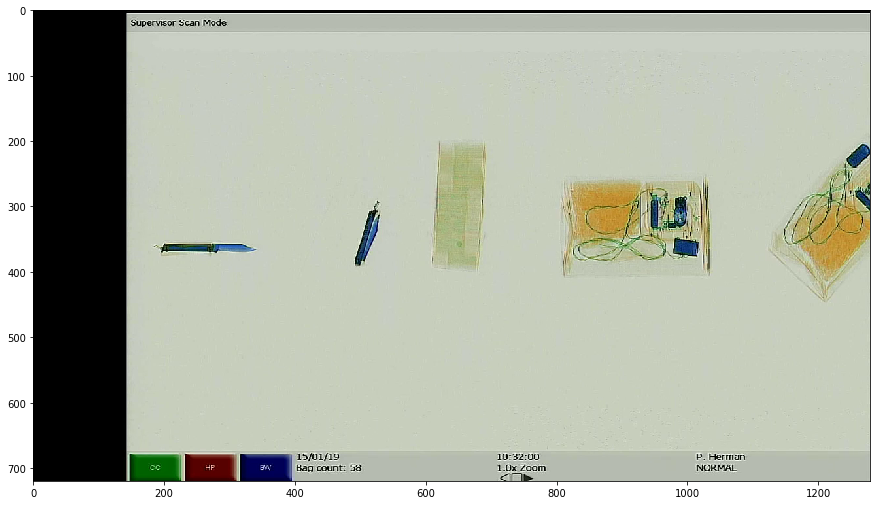

In [15]:
import json
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from io import BytesIO

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket)

# Read single json file in s3 bucket
jsonfile = bucket.Object(train_annotation_channel + "/14_rotate_0.json")
file_content = jsonfile.get()["Body"].read().decode("utf-8")
json_content = json.loads(file_content)
for anno in json_content["annotations"]:
    print(anno)
print(json.dumps(json_content, indent=2, sort_keys=True))

# Read single image in s3 bucket
imgfile = bucket.Object(train_channel + "/14_rotate_0.png")
image = mpimg.imread(BytesIO(imgfile.get()["Body"].read()), "jp2")
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(image)

# Read all files in specific s3 bucket folder
print("Start to read files from {}/{} ......".format(BUCKET, train_channel))
count = 0
print(bucket.objects.filter(Prefix=train_channel))
for image in bucket.objects.filter(Prefix=train_channel):
    count += 1 
    # use image.key will return augmenter/xxxx/xxx.png of xxx.json
    # which can be used directly in bucket.Object() 

print("Done. Total number of files: {}".format(count))

## Read Image File from S3 Bucket Using s3fs

You may also use the module called s3fs to read image file from S3 Bucket.

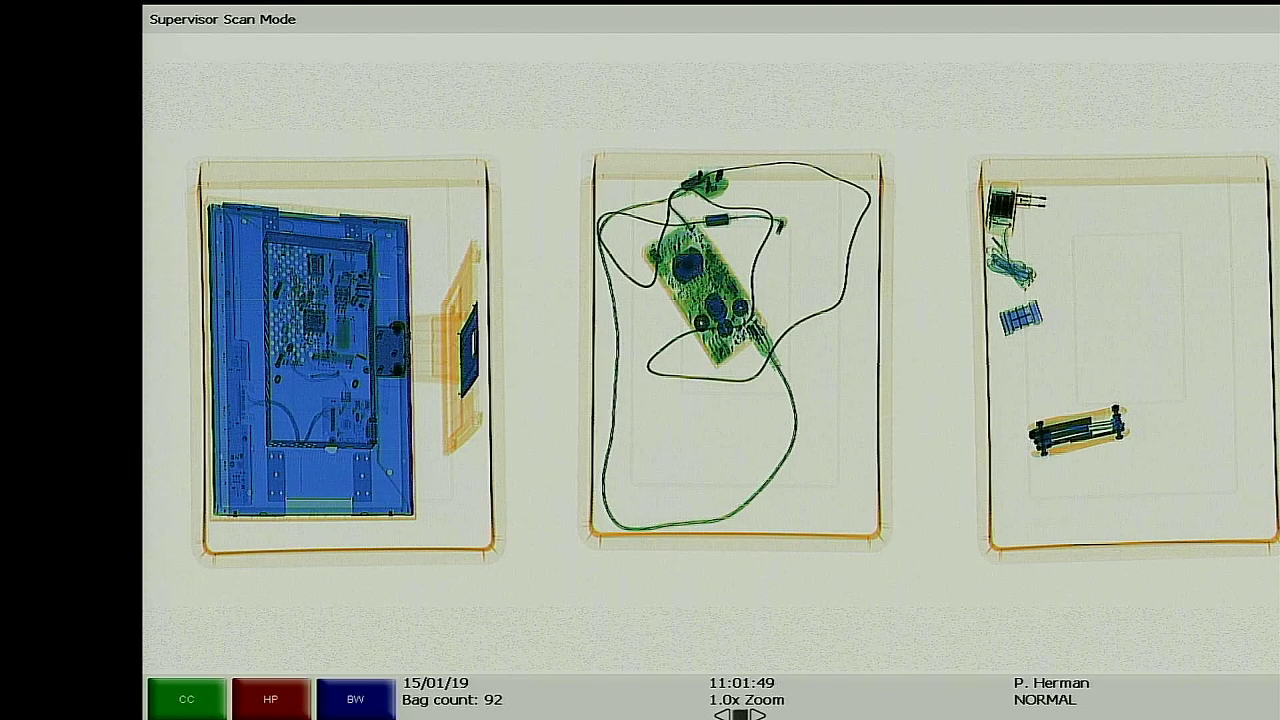

In [11]:
import s3fs
from PIL import Image

fs = s3fs.S3FileSystem()
with fs.open("s3://sagemaker-us-east-1-867716085216/augmenter/training_img/100_rotate_0.png", "rb") as f:
    display(Image.open(f))

## Convert image json to csv

In [ ]:
import json
import boto3
import pandas as pd

csv_list = []
column_name = ["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"]

BUCKET = "sagemaker-us-east-1-867716085216"
PREFIX = "augmenter"
train_annotation_channel = PREFIX + "/training_anno_110619"
validation_annotation_channel = PREFIX + "/validation_anno_110619"

s3 = boto3.resource('s3')
bucket = s3.Bucket(BUCKET)

# Run twice for training and validation annotation files
for jsonfile in bucket.objects.filter(Prefix=train_annotation_channel):
    print("Processing {} ......".format(jsonfile.key))
    read_file = bucket.Object(jsonfile.key)
    file_content = read_file.get()["Body"].read().decode()
    if file_content == "":
        continue
    json_data = json.loads(file_content)
    for i, a in enumerate(json_data["annotations"]):
        value = (
            jsonfile.key.split("/")[2][:-5]+".png",
            json_data["image_size"][0]["width"],
            json_data["image_size"][0]["height"],
            next(item for item in json_data["categories"] if item["class_id"] == a["class_id"])["name"],
            a["left"],
            a["top"],
            a["left"]+a["width"],
            a["top"]+a["height"]
        )
        csv_list.append(value)
    print("Done Update CSV List for {}.".format(jsonfile.key))

csv_df = pd.DataFrame(csv_list, columns=column_name)

## Convert DataFrame to CSV

In [ ]:
csv_df

In [ ]:
csv_df
csv_df.to_csv("training_data_labels.csv", index=None)
print("Successful convert json files to csv.")

## Generate Label Map

We will use classes.txt to generate pbtxt for tensorflow. This file should be placed inside annotation folder. 

In [ ]:
end = "\n"
s = " "
output_name = "label_map.pbtxt"

classtxt = open("mxnet-training-data/classes.txt", "r")
for id, classname in enumerate(classtxt):
    print(id, classname)
    out = ""
    out += "item" + s + "{" + end
    out += s*2 + "id:" + " " + (str(id+1)) + end
    out += s*2 + "name:" + " " + "\"" + classname.strip("\n") + "\"" + end
    out += "}" + end*2
    with open(output_name, "a") as f:
        f.write(out)

## Upload CSV files and Label Map to S3 Bucket

In [ ]:
import logging
import boto3
from botocore.exceptions import ClientError

def upload_file(file_name, bucket, object_name=None):
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client("s3")
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

s3 = boto3.client("s3")
# Run the same process for both csv and label map
with open("training_data_labels.csv", "rb") as f:
    s3.upload_fileobj(f, "sagemaker-us-east-1-867716085216", "training_data_labels.csv")

## Generate TFRecord from CSV

In [ ]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import s3fs
import boto3
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

fs = s3fs.S3FileSystem()

# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'key':
        return 1
    elif row_label == 'other_electronic':
        return 2
    elif row_label == 'water_bottle':
        return 3
    elif row_label == 'handphone':
        return 4
    elif row_label == 'umbrella':
        return 5
    elif row_label == 'other':
        return 6
    elif row_label == 'knife':
        return 7
    elif row_label == 'powerbank':
        return 8
    elif row_label == 'laptop':
        return 9
    elif row_label == 'Personal Item':
        return 10
    elif row_label == 'other_weapon':
        return 11
    elif row_label == 'other_liquid':
        return 12
    elif row_label == 'scissors':
        return 13
    elif row_label == 'other_item':
        return 14
    elif row_label == 'Electronic':
        return 15
    elif row_label == 'guns':
        return 16
    elif row_label == 'Opaque':
        return 17
    elif row_label == 'Liquid':
        return 18
    elif row_label == 'metal_pipes':
        return 19
    elif row_label == 'catridges':
        return 20
    elif row_label == 'rifles':
        return 21
    elif row_label == 'bombs':
        return 22
    else:
        None

def split(df, group):
    data = namedtuple("data", ["filename", "object"])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    print(path+"/"+group.filename)
    with fs.open(path+"/"+group.filename, "rb") as f:
        encoded_png = f.read()
    encoded_png_io = io.BytesIO(encoded_png)
    image = Image.open(encoded_png_io)
    width, height = image.size

    filename = group.filename.encode("utf8")
    image_format = b'png'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_png),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main():
    writer = tf.python_io.TFRecordWriter("training.tfrecord") # Change to desire output name
    path = os.path.join(s3_train_data)
    examples = pd.read_csv(s3_train_annotation)
    grouped = split(examples, "filename")
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    print("Successfully created the TFRecords: {}".format("training.tfrecord"))

main()

## Read TFRecord from S3 Bucekt

In [12]:
import tensorflow as tf

tf.enable_eager_execution()
raw_image_dataset = tf.data.TFRecordDataset(s3_tfrecord+"/training.tfrecord") #Or validation.tfrecord

image_feature_description = {
    'height': tf.FixedLenFeature([], tf.int64),
    'width': tf.FixedLenFeature([], tf.int64),
    'depth': tf.FixedLenFeature([], tf.int64),
    'label': tf.FixedLenFeature([], tf.int64),
    'image_raw': tf.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

parsed_image_dataset

<DatasetV1Adapter shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>